In [11]:
import os
import numpy as np
import pandas as pd 
import random
import cv2
import matplotlib.pyplot as plt

In [12]:
import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
import keras.saving
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf
import pickle

In [13]:
seed = 232
np.random.seed(seed)
tf.random.set_seed(seed)

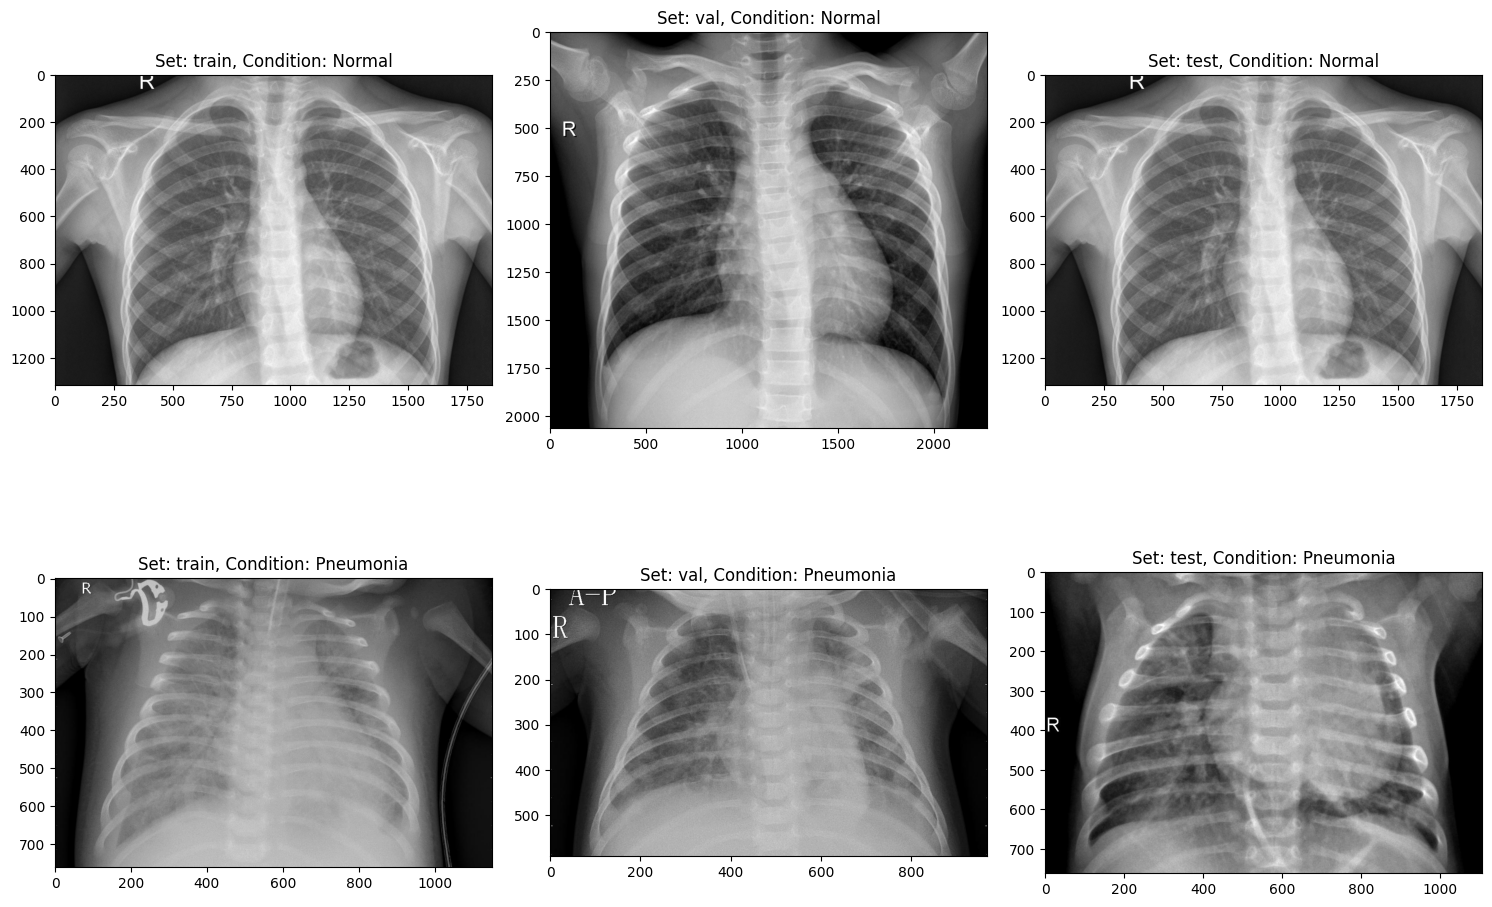

In [14]:
path = './Data/'

fig, ax = plt.subplots(2, 3, figsize=(15, 10))
ax = ax.ravel()
plt.tight_layout()

for i, _set in enumerate(['train', 'val', 'test']):
    set_path = path + _set
    ax[i].imshow(plt.imread(set_path+'/NORMAL/'+os.listdir(set_path+'/NORMAL')[0]), cmap='gray')
    ax[i].set_title('Set: {}, Condition: Normal'.format(_set))
    
    ax[i+3].imshow(plt.imread(set_path+'/PNEUMONIA/'+os.listdir(set_path+'/PNEUMONIA')[0]), cmap='gray')
    ax[i+3].set_title('Set: {}, Condition: Pneumonia'.format(_set))

In [15]:
def process_data(img_dims, batch_size):
    
    # Data generation objects
    train_datagen = image_gen = ImageDataGenerator(
                                  rescale = 1./255,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True,          
                                )
    
    test_val_datagen = ImageDataGenerator(
                                    rescale=1./255
                                )
    
    # This is fed to the network in the specified batch sizes and image dimensions
    train_gen = train_datagen.flow_from_directory(
                    directory= path + 'train', 
                    target_size=(img_dims, img_dims), 
                    batch_size=batch_size, 
                    class_mode='binary', 
                    shuffle=True)

    test_gen = test_val_datagen.flow_from_directory(
                    directory= path + 'test', 
                    target_size=(img_dims, img_dims), 
                    batch_size=batch_size, 
                    class_mode='binary', 
                    shuffle=True)
    
    val_gen = test_val_datagen.flow_from_directory(
                    directory= path + 'val', 
                    target_size=(img_dims, img_dims), 
                    batch_size=batch_size, 
                    class_mode='binary', 
                    shuffle=True)
    
    test_data = []
    test_labels = []

    for cond in ['/NORMAL/', '/PNEUMONIA/']:
        for img in (os.listdir(path + 'test' + cond)):
            img = plt.imread(path + 'test' + cond + img)
            img = cv2.resize(img, (img_dims, img_dims))
            img = np.dstack([img, img, img])
            img = img.astype('float32') / 255
            if cond=='/NORMAL/':
                label = 0
            elif cond=='/PNEUMONIA/':
                label = 1
            test_data.append(img)
            test_labels.append(label)
        
    test_data = np.array(test_data)
    test_labels = np.array(test_labels)
    
    return train_gen, test_gen, test_data, test_labels

In [16]:
img_dims = 224
epochs = 10
batch_size = 32

train_gen, test_gen, test_data, test_labels = process_data(img_dims, batch_size)

Found 5450 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 18 images belonging to 2 classes.


In [17]:
## CNN Architecture

inputs = Input(shape=(img_dims, img_dims, 3))

# First conv block
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Second conv block
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Third conv block
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Fourth conv block
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# Fifth conv block
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# FC layer
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(rate=0.7)(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(units=64, activation='relu')(x)
x = Dropout(rate=0.3)(x)

# Output layer
output = Dense(units=1, activation='sigmoid')(x)

# Creating model and compiling
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint(filepath='best.weights.h5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

In [25]:
hist = model.fit(
           train_gen, steps_per_epoch=train_gen.samples // batch_size, 
           epochs=7, validation_data=test_gen, 
           validation_steps=test_gen.samples // batch_size, callbacks=[checkpoint, lr_reduce])

Epoch 1/7
170/170 ━━━━━━━━━━━━━━━━━━━━ 219s 1s/step - accuracy: 0.9289 - loss: 0.1989 - val_accuracy: 0.6266 - val_loss: 0.8115 - learning_rate: 3.0000e-04
Epoch 2/7
  1/170 ━━━━━━━━━━━━━━━━━━━━ 2:06 748ms/step - accuracy: 0.9688 - loss: 0.1110

c:\Python311\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9688 - loss: 0.0558 - val_accuracy: 0.5625 - val_loss: 0.4248 - learning_rate: 3.0000e-04
Epoch 3/7
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9241 - loss: 0.2089
Epoch 3: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
170/170 ━━━━━━━━━━━━━━━━━━━━ 208s 1s/step - accuracy: 0.9241 - loss: 0.2088 - val_accuracy: 0.8240 - val_loss: 0.3867 - learning_rate: 3.0000e-04
Epoch 4/7
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9062 - loss: 0.0634 - val_accuracy: 0.8125 - val_loss: 0.1767 - learning_rate: 9.0000e-05
Epoch 5/7
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9334 - loss: 0.1660
Epoch 5: ReduceLROnPlateau reducing learning rate to 2.700000040931627e-05.
170/170 ━━━━━━━━━━━━━━━━━━━━ 236s 1s/step - accuracy: 0.9334 - loss: 0.1660 - val_accuracy: 0.9194 - val_loss: 0.2232 - learning_rate: 9.0000e-05
Epoch 6/7
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8750 - loss: 0.1224 - v

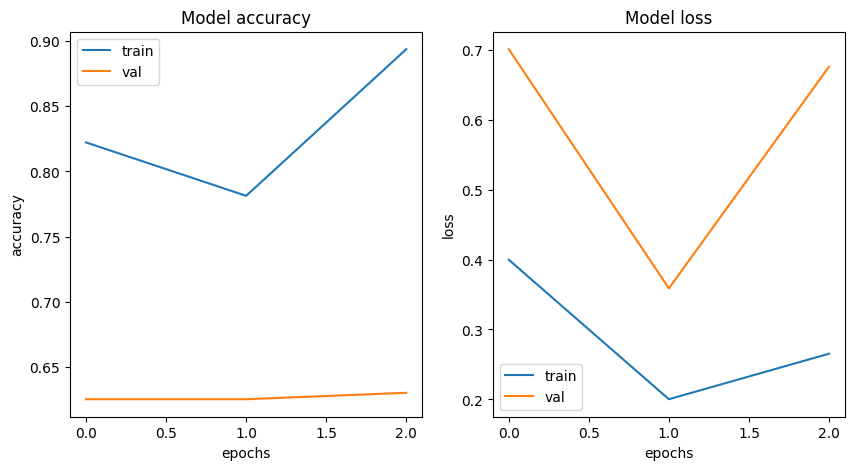

In [19]:
keras.saving.save_model(model, "PneumoniaPredictorV2.keras")
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    
    ax[i].set_title('Model {}'.format(met))
    
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    
    ax[i].legend(['train', 'val'])

In [27]:
from sklearn.metrics import accuracy_score, confusion_matrix

preds = model.predict(test_data)

acc = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC ----------------------')
print('Train acc: {}'.format(np.round((hist.history['accuracy'][-1])*100, 2)))

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 177ms/step
CONFUSION MATRIX ------------------
[[194  40]
 [ 15 375]]

TEST METRICS ----------------------
Accuracy: 91.18589743589743%
Precision: 90.36144578313254%
Recall: 96.15384615384616%
F1-score: 93.16770186335403

TRAIN METRIC ----------------------
Train acc: 94.39


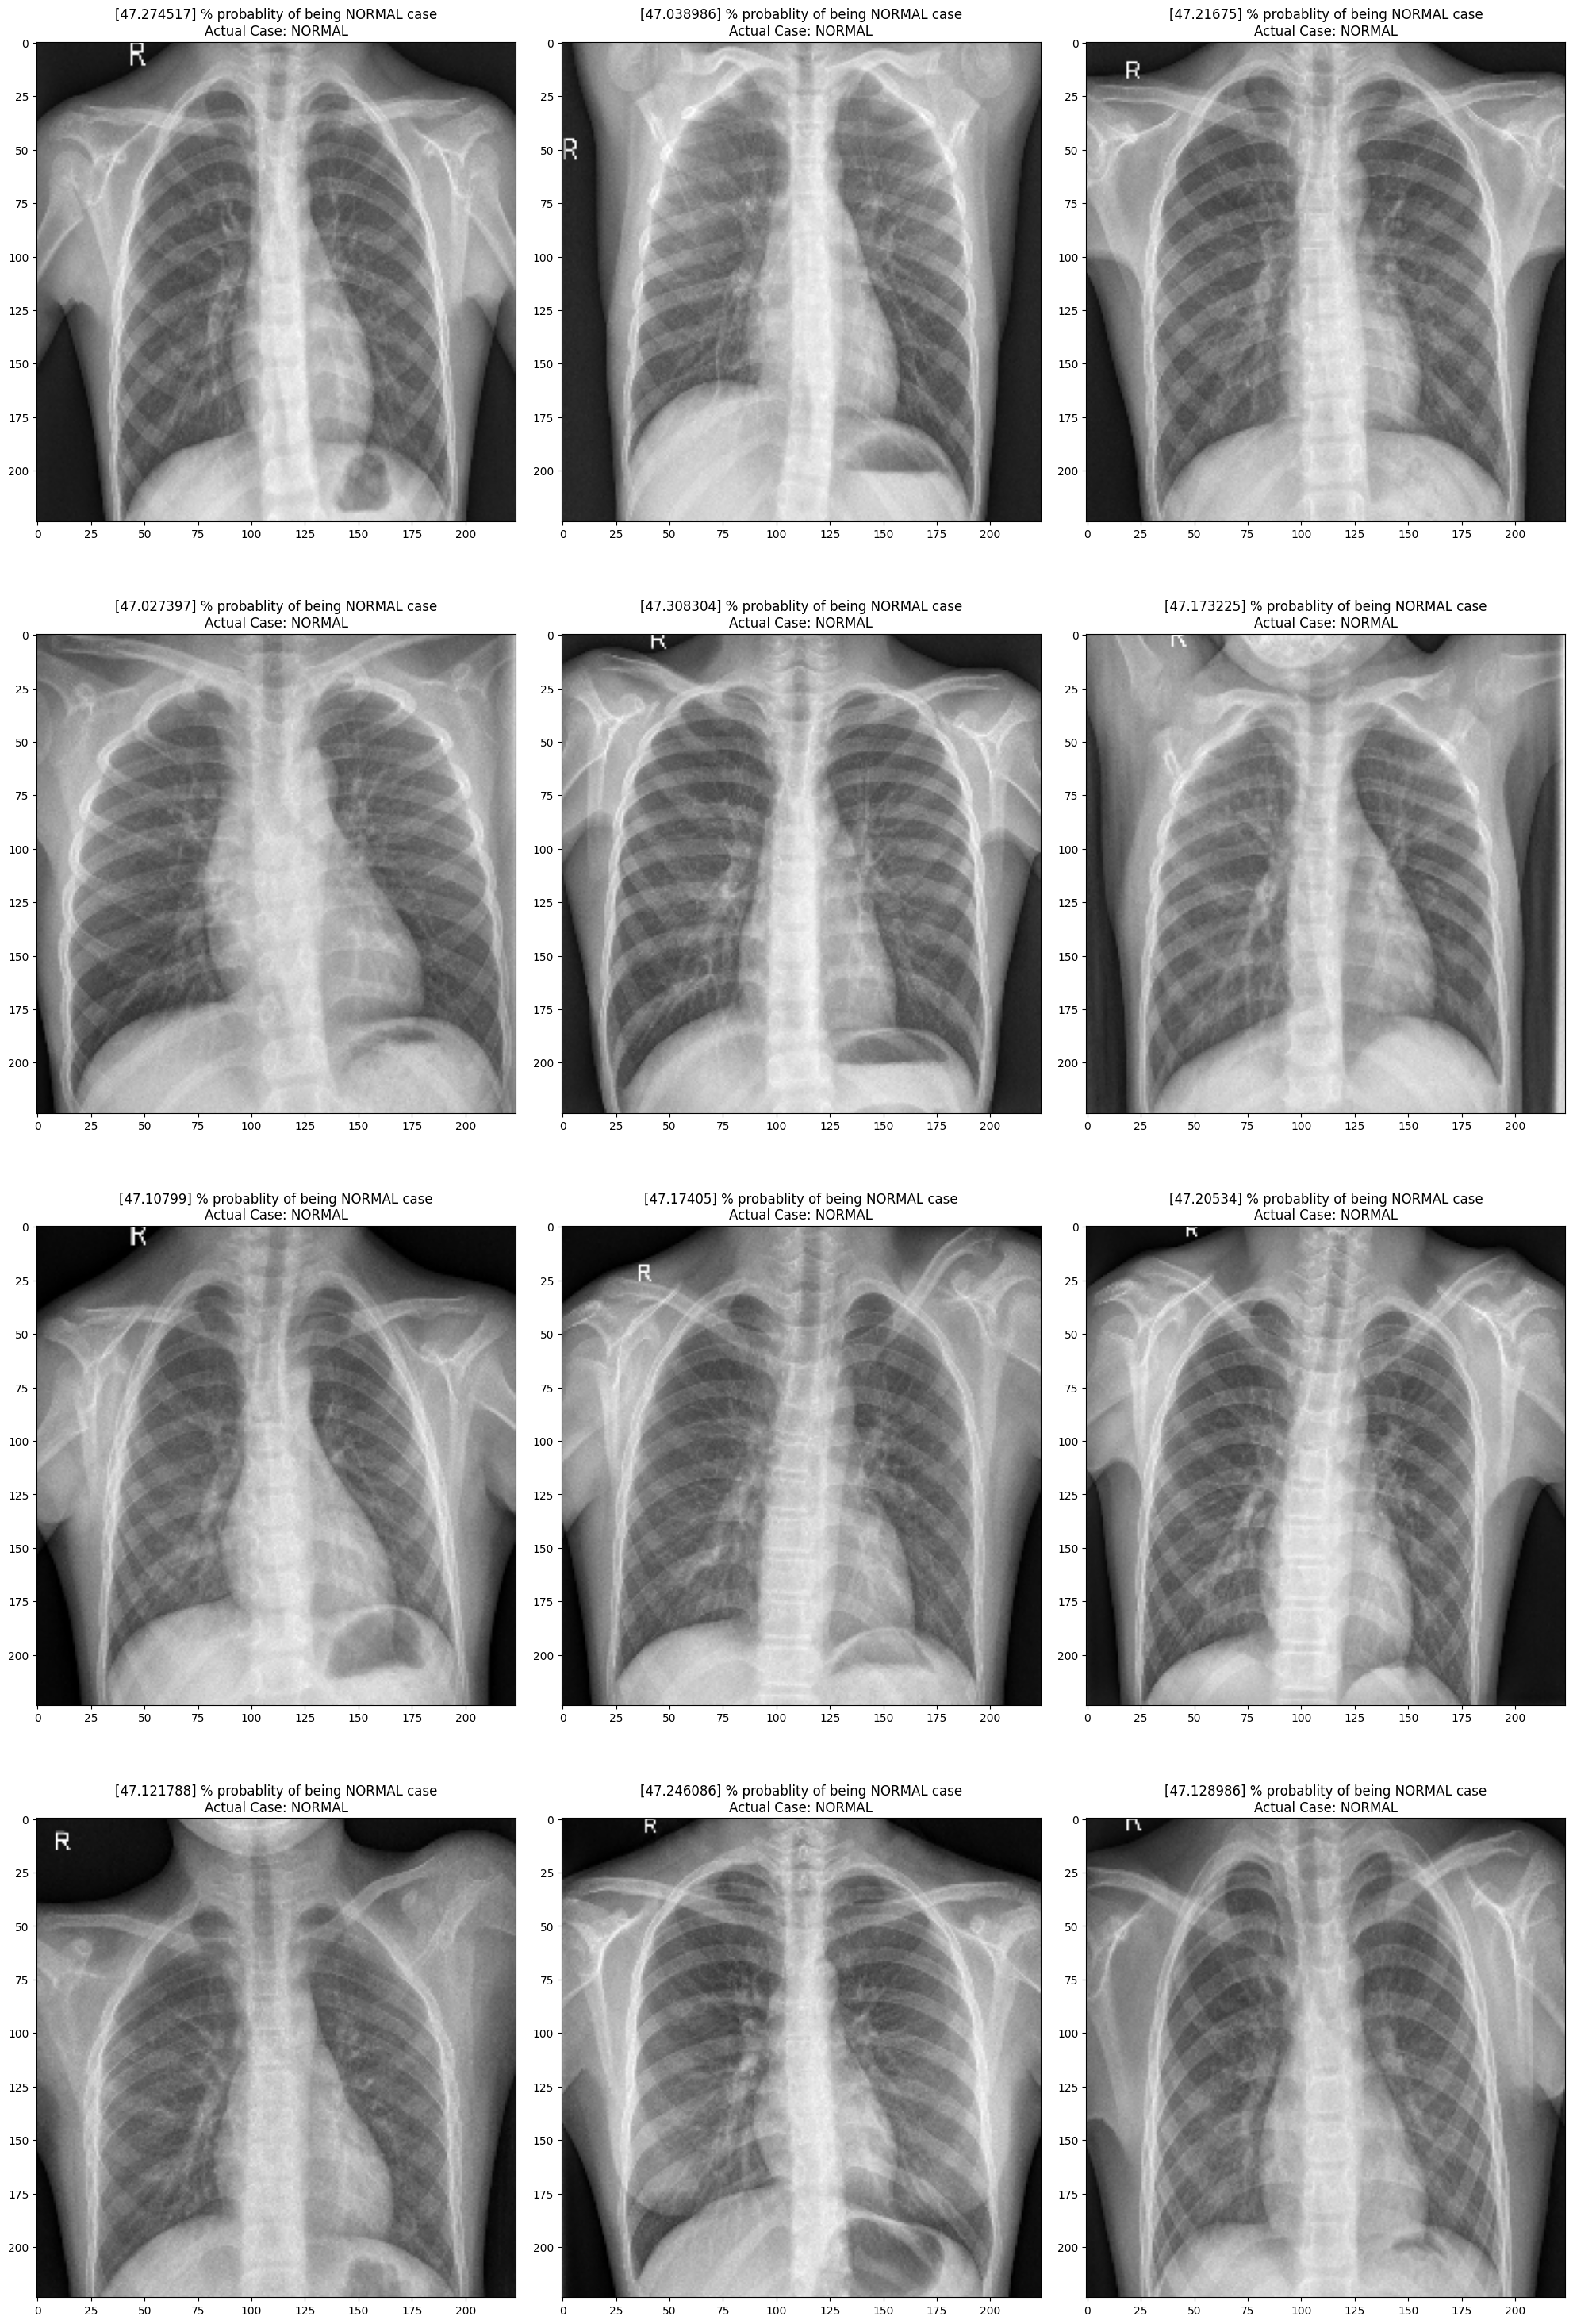

In [21]:
fig, ax = plt.subplots(4, 3, figsize=(20, 30))
ax = ax.ravel()
plt.tight_layout()

for i in range(12):
    ax[i].imshow(test_data[i], cmap='gray')
    
    if test_labels[i] == 0:
        ax[i].set_title('{} % probablity of being NORMAL case'.format((1 - preds[i])*100) + '\n' + 'Actual Case: NORMAL')
    else:
        ax[i].set_title('{} % probablity of being PNEUMONIA case'.format(preds[i]*100) + '\n' + 'Actual Case: PNEUMONIA')

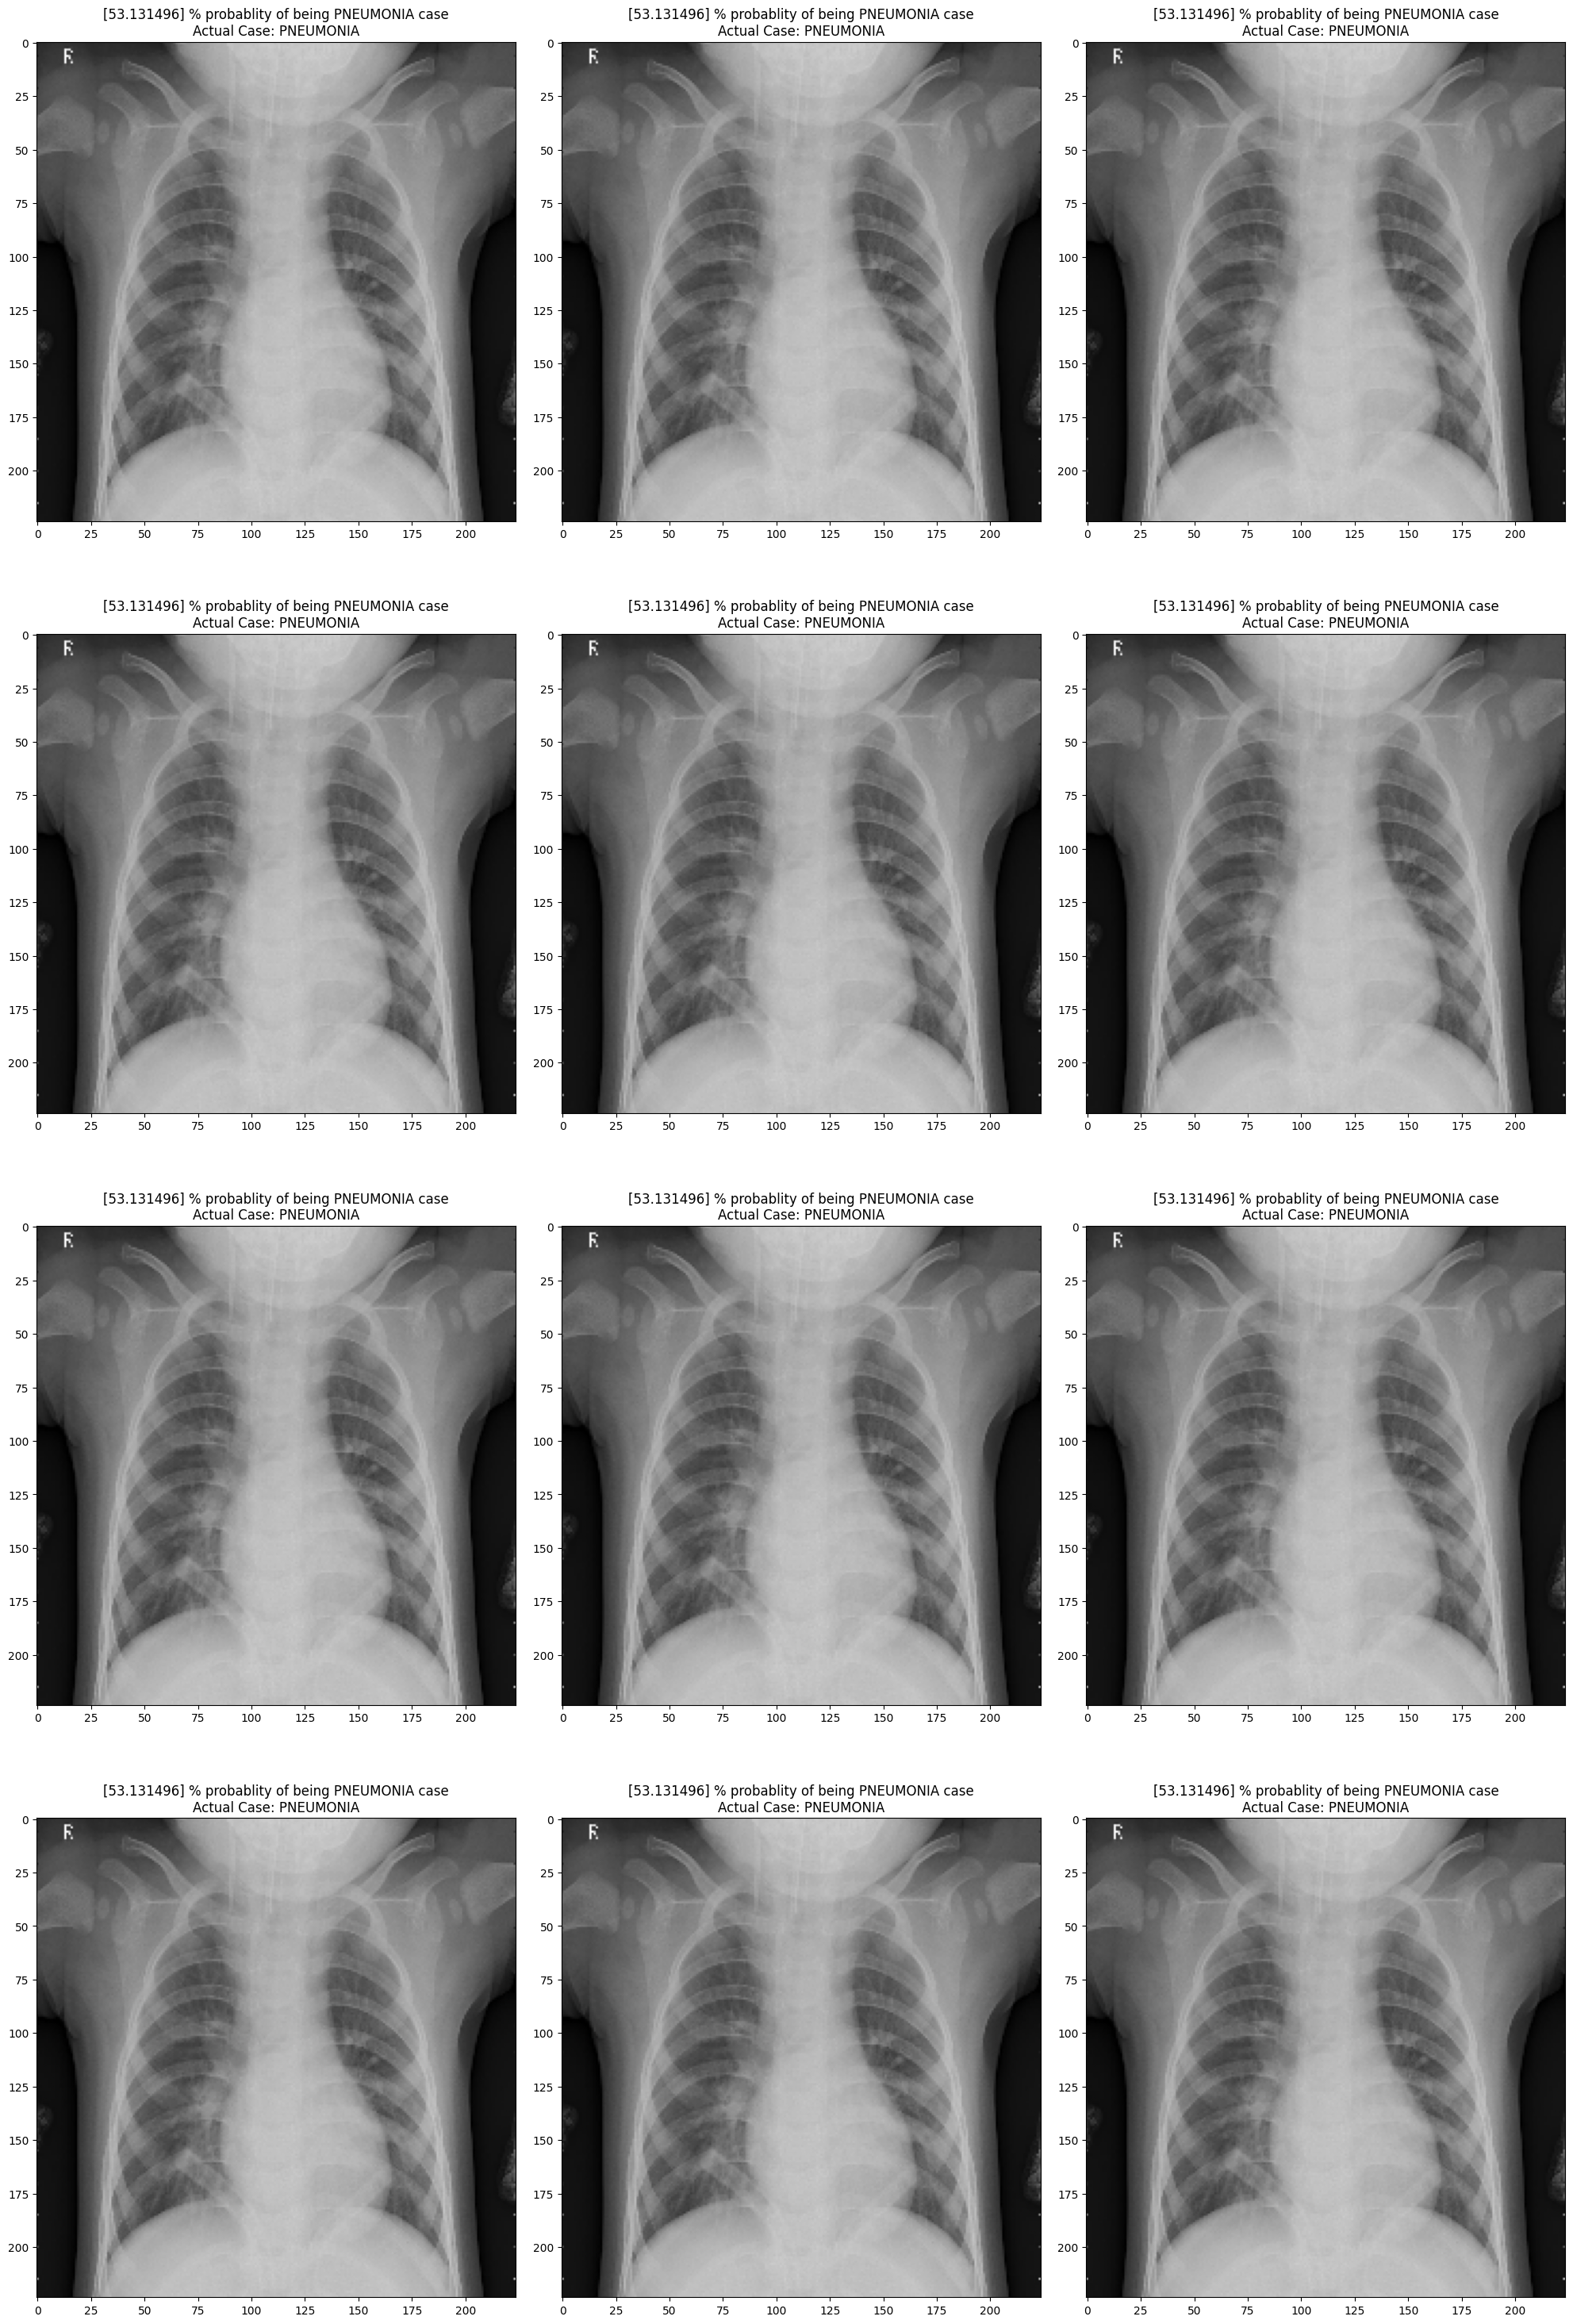

In [22]:
fig, ax = plt.subplots(4, 3, figsize=(20, 30))
ax = ax.ravel()
plt.tight_layout()

for i in range(12):
    for j in range(234, 246):
        ax[i].imshow(test_data[j])
    
        if test_labels[j] == 0:
            ax[i].set_title('{} % probablity of being NORMAL case'.format((1 - preds[j])*100) + '\n' + 'Actual Case: NORMAL')
        else:
            ax[i].set_title('{} % probablity of being PNEUMONIA case'.format(preds[j]*100) + '\n' + 'Actual Case: PNEUMONIA')

In [23]:
filename = 'PneumoniaPredictor.keras'
#model.save(filename)
model2 = keras.saving.load_model(filename)
model2.summary()
import visualkeras
from PIL import ImageFont
font = ImageFont.truetype("arial.ttf", 32)  # using comic sans is strictly prohibited!
visualkeras.layered_view(model2, legend=True, font=font)  # font is optional!

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 224, 224, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_32             │ (None, 112, 112, 32)   │           688 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_33             │ (None, 112, 112, 32)   │         1,344 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_34             │ (None, 56, 56, 64)     │         2,400 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_35             │ (None, 56, 56, 64)     │         4,736 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_36             │ (None, 28, 28, 128)    │         8,896 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_37             │ (None, 28, 28, 128)    │        17,664 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_38             │ (None, 14, 14, 256)    │        34,176 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_39             │ (None, 14, 14, 256)    │        68,096 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 19,917,221 (75.98 MB)

 Trainable params: 6,638,753 (25.32 MB)

 Non-trainable params: 960 (3.75 KB)

 Optimizer params: 13,277,508 (50.65 MB)

AttributeError: 'InputLayer' object has no attribute 'output_shape'

In [ ]:
import pydot
from keras.utils import model_to_dot

# Assuming you have your Keras model defined as 'model'

dot = model_to_dot(model2, show_shapes=True)  # Include layer shapes
graph = pydot.graph_from_dot_data(dot.generate())
graph.write_png('model_architecture.png')  # Save the visualization as PNG


AttributeError: 'Dot' object has no attribute 'generate'